In [1]:
!pip install opencv-python
!pip install numpy
!pip install imgaug
!pip install matplotlib
!pip install scikit-learn
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 46.1 MB/s eta 0:00:0000:01


In [2]:
import cv2
import numpy as np
import imgaug.augmenters as iaa
from imgaug.augmenters import contrast
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D , BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,TensorBoard
from keras import layers

from keras.applications import VGG16
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, confusion_matrix

In [3]:
ben_train = os.listdir('benign')
mal_train = os.listdir('malignant') 

In [4]:
# create the augmentation sequence
seq = iaa.Sequential([
    iaa.Flipud(0.5),
    iaa.Affine(rotate=(-45, 45)),
    iaa.Multiply((0.0, 1.5), per_channel=False),
    iaa.LinearContrast((0.5, 2.0))
])

#seq2 = iaa.Sequential([
#    iaa.Flipud(0.5),
#    iaa.Affine(rotate=(-45, 45)),
#    iaa.Multiply((0.0, 1.5), per_channel=False),
#    iaa.LinearContrast((0.5, 2.0))
#])


In [5]:
train = []
train_y = []

In [6]:
for i in ben_train:
    x = 'benign/' + i
    img = cv2.cvtColor(cv2.imread(x), cv2.COLOR_BGR2RGB)
    img = img.astype('float32')/255 # normalise image
    img = cv2.resize(img,(200,200))
    train.append(img.flatten())
    train_y.append(0) # label 0 for benign

    # Augment the image
    for j in range(5):
        augmented_img = seq.augment_image(img)
        train.append(augmented_img.flatten())
        train_y.append(0)
    
    
for i in mal_train:
    x = 'malignant/' + i
    img = cv2.cvtColor(cv2.imread(x), cv2.COLOR_BGR2RGB)
    img = img.astype('float32')/255 # normalise image
    img = cv2.resize(img,(200,200))
    train.append(img.flatten())
    train_y.append(1) # label 0 for benign

    # Augment the image
    for j in range(5):
        augmented_img = seq.augment_image(img)
        train.append(augmented_img.flatten())
        train_y.append(1)
    
    

In [7]:
print(len(train))
print(len(train_y))

9660
9660


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


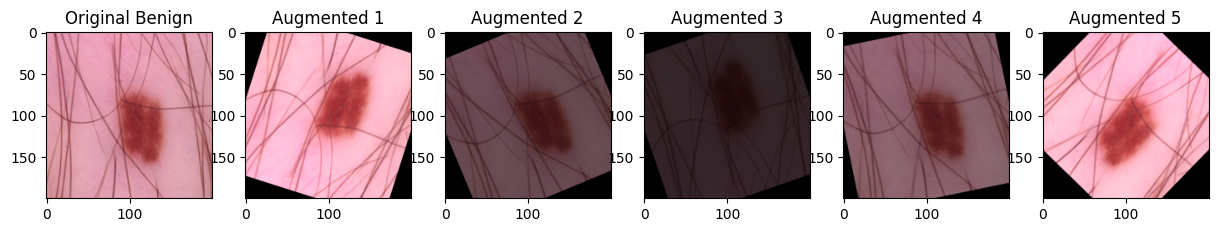

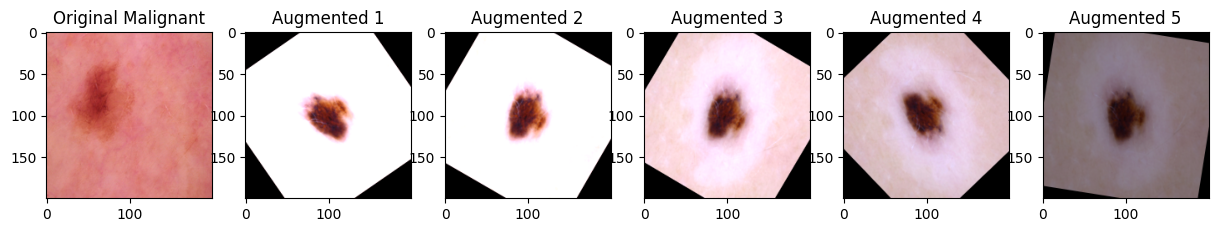

In [9]:
import matplotlib.pyplot as plt

# Select an example benign image
example_index_ben = 0  # Change this to the index of the image you want to plot
example_image_ben = train[example_index_ben].reshape(200, 200, 3)

# Create a subplot to show the original image and its augmented versions
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15, 3))

# Plot the original image
axes[0].imshow(example_image_ben)
axes[0].set_title("Original Benign")

# Plot the augmented images
for i in range(1, 6):
    augmented_image = train[(example_index_ben * 5) + i].reshape(200, 200, 3)
    axes[i].imshow(augmented_image)
    axes[i].set_title("Augmented " + str(i))

# Select an example malignant image
example_index_mal = len(mal_train)  # Change this to the index of the image you want to plot
example_image_mal = train[example_index_mal].reshape(200, 200, 3)

# Create a subplot to show the original image and its augmented versions
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15, 3))

# Plot the original image
axes[0].imshow(example_image_mal)
axes[0].set_title("Original Malignant")

# Plot the augmented images
for i in range(1, 6):
    augmented_image = train[(example_index_mal * 5) + i].reshape(200, 200, 3)
    axes[i].imshow(augmented_image)
    axes[i].set_title("Augmented " + str(i))

# Show the plots
plt.show()

In [8]:
train = np.array(train) 

In [9]:
print(train)

[[0.9091263  0.61916554 0.7257114  ... 0.7446918  0.5013475  0.51929414]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [10]:
train,val,train_y,val_y = train_test_split(train,train_y,test_size=0.2,random_state=44)
train = train.reshape(train.shape[0],200,200,3)
val = val.reshape(val.shape[0],200,200,3)
encoder = LabelEncoder() # transform the labels so they can be read by the machine easily 
encoder = encoder.fit(train_y) # pass through the y labels 
train_y = encoder.transform(train_y) # transfrom the labels 
encoder = encoder.fit(val_y)
val_y = encoder.transform(val_y)
print(str('training rows ' + str(len(train)))) # print the length of training data 
print(str('validation rows ' + str(len(val)))) # validation or test data 

training rows 7728
validation rows 1932


In [15]:


# Load the VGG16 model without the top layer
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(200,200,3))

# Freeze the layers so that they are not trainable
for layer in vgg.layers:
    layer.trainable = False

In [16]:
# Set up the model
model = Sequential()
model.add(vgg)
model.add(layers.Flatten())
model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               9437696   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 24,152,897
Trainable params: 9,438,209
Non-trainable params: 14,714,688
_________________________________________________________________


In [13]:
model = Sequential()
model.add(vgg)
model.add(layers.Flatten())
model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model


In [17]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.3, min_lr=0.000001)
early_stop = EarlyStopping(patience=4,restore_best_weights=True)
tensorboard = TensorBoard(log_dir='logs')



In [18]:
history = model.fit(train,train_y,epochs=10,batch_size=32,validation_data=(val,val_y),verbose=2,callbacks=[early_stop,reduce_lr,tensorboard])

2023-05-07 20:54:57.052275: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3709440000 exceeds 10% of free system memory.
2023-05-07 20:55:01.379933: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3709440000 exceeds 10% of free system memory.


Epoch 1/10
242/242 - 34s - loss: 0.5691 - accuracy: 0.7732 - val_loss: 0.3436 - val_accuracy: 0.8571 - lr: 0.0010 - 34s/epoch - 140ms/step
Epoch 2/10
242/242 - 32s - loss: 0.3592 - accuracy: 0.8366 - val_loss: 0.3309 - val_accuracy: 0.8530 - lr: 0.0010 - 32s/epoch - 134ms/step
Epoch 3/10
242/242 - 32s - loss: 0.2794 - accuracy: 0.8710 - val_loss: 0.2607 - val_accuracy: 0.8732 - lr: 0.0010 - 32s/epoch - 134ms/step
Epoch 7/10
242/242 - 32s - loss: 0.2674 - accuracy: 0.8785 - val_loss: 0.2471 - val_accuracy: 0.8835 - lr: 0.0010 - 32s/epoch - 134ms/step
Epoch 8/10
242/242 - 32s - loss: 0.2688 - accuracy: 0.8738 - val_loss: 0.2514 - val_accuracy: 0.8763 - lr: 0.0010 - 32s/epoch - 134ms/step
Epoch 9/10
242/242 - 32s - loss: 0.2501 - accuracy: 0.8868 - val_loss: 0.2447 - val_accuracy: 0.8799 - lr: 0.0010 - 32s/epoch - 134ms/step
Epoch 10/10
242/242 - 33s - loss: 0.2495 - accuracy: 0.8854 - val_loss: 0.2336 - val_accuracy: 0.8944 - lr: 0.0010 - 33s/epoch - 134ms/step


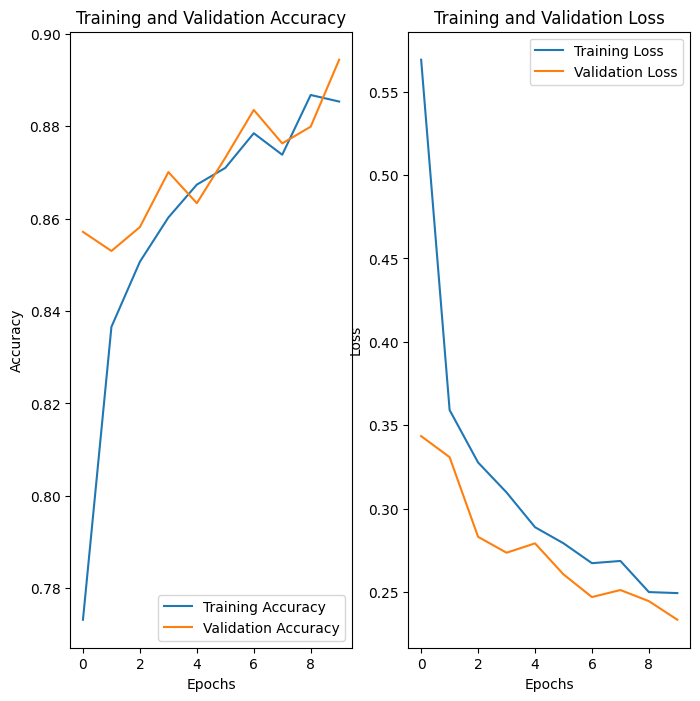

In [19]:
epochs=10
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

61/61 [==============================] - 7s 104ms/step
{'f1': 0.8360128617363344, 'precision': 0.9138840070298769, 'recall': 0.7703703703703704}


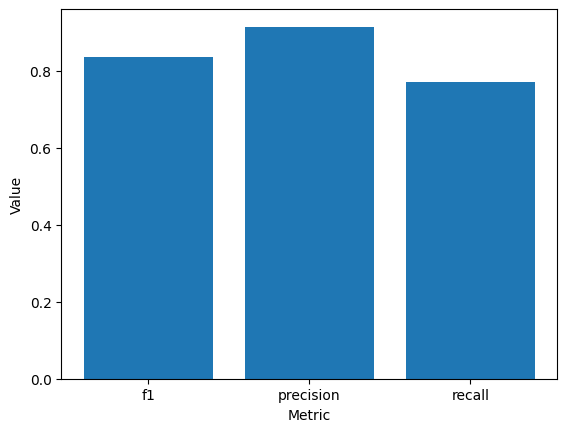

In [20]:
# Make predictions on validation data
val_pred = model.predict(val)
val_pred = np.round(val_pred)
val_pred = val_pred.flatten()

# Calculate metrics
f1 = f1_score(val_y, val_pred)
precision = precision_score(val_y, val_pred)
recall = recall_score(val_y, val_pred)

# Create a dictionary of metrics
metrics = {'f1':f1, 'precision':precision, 'recall':recall}

# Print metrics
print(metrics)

# Plot the metrics in a bar chart
import matplotlib.pyplot as plt

plt.bar(metrics.keys(), metrics.values())
plt.xlabel('Metric')
plt.ylabel('Value')
plt.show()

In [21]:
ben_test = os.listdir('benign_test')
mal_test = os.listdir('malignant_test')

In [22]:
test = []
test_y = []
for i in ben_test:
    x = 'benign_test/' + i
    img = cv2.imread(x)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(200,200))
    img = img/255 # normalising 
    test.append(img)
    test_y.append(0)
for i in mal_test:
    x = 'malignant_test/' + i
    img = cv2.imread(x)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(200,200))
    img = img/255 # normalising 
    test.append(img)
    test_y.append(1)
test = np.array(test)
encoder = LabelEncoder()
encoder = encoder.fit(test_y)
test_y = encoder.transform(test_y)
loss,acc = model.evaluate(test, test_y,verbose=2)
print('Accuracy on test data: '+ str(acc))
print('Loss on test data: ' + str(loss))

21/21 - 3s - loss: 0.5081 - accuracy: 0.8121 - 3s/epoch - 141ms/step
Accuracy on test data: 0.8121212124824524
Loss on test data: 0.5080543160438538


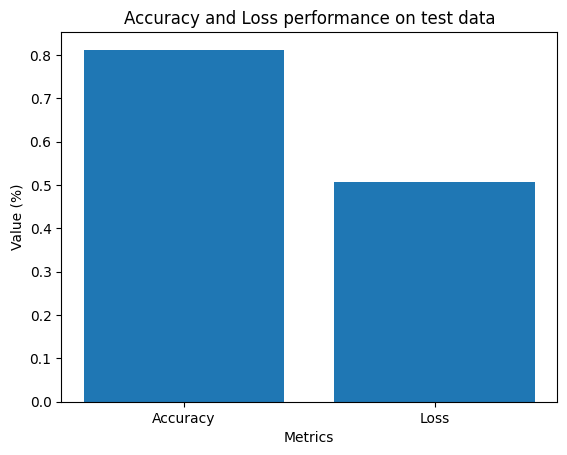

In [23]:
# Create a bar chart
plt.bar(['Accuracy', 'Loss'], [acc, loss])

# Add labels to the x and y axis
plt.xlabel('Metrics')
plt.ylabel('Value (%)')
plt.title("Accuracy and Loss performance on test data")

# Show the plot
plt.show()

In [24]:
predictions = model.predict(test)
predictions = (predictions >= 0.5).astype(int)
actual = test_y

21/21 [==============================] - 2s 104ms/step


In [25]:
# Get predictions for test set
probabilities = model.predict(test)

# Round probabilities to nearest integer (0 or 1)
predicted_labels = np.round(probabilities)

# Count the number of predicted benign and malignant samples
num_benign = np.count_nonzero(predicted_labels == 0)
num_malignant = np.count_nonzero(predicted_labels == 1)

# Calculate the percentage of each class
percent_benign = (num_benign / len(predicted_labels)) * 100
percent_malignant = (num_malignant / len(predicted_labels)) * 100

# Print the percentages
print(f"Predicted benign: {percent_benign:.2f}%")
print(f"Predicted malignant: {percent_malignant:.2f}%")


21/21 [==============================] - 2s 104ms/step
Predicted benign: 67.58%
Predicted malignant: 32.42%


In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


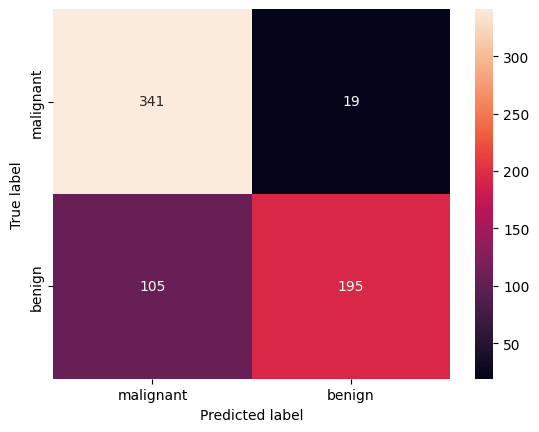

In [27]:
cm = confusion_matrix(actual, predictions)

sns.heatmap(cm, annot=True, fmt='d', xticklabels=['malignant', 'benign'], yticklabels=['malignant', 'benign'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [25]:
model.save("model_new_vgg16.h5")

In [26]:
from tensorflow.keras.models import load_model


In [27]:

# Load the model from the saved .h5 file
model = load_model('model_new_vgg16.h5')

In [28]:
import tensorflow as tf

In [29]:
# Convert the Keras model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()



INFO:tensorflow:Assets written to: /tmp/tmpu73z1m8q/assets


INFO:tensorflow:Assets written to: /tmp/tmpu73z1m8q/assets
2023-04-29 16:35:05.742496: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-04-29 16:35:05.742545: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


In [35]:
import os

# Create a folder named 'tflite_models' if it doesn't exist
if not os.path.exists('tflite_models'):
    os.makedirs('tflite_models')

# Save the TensorFlow Lite model to the folder
with open('tflite_models/model.tflite', 'wb') as f:
    f.write(tflite_model)

FileNotFoundError: [Errno 2] No such file or directory: 'path/to/tflite/model.tflite'